In [17]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [18]:
# change to your data path if necessary
DATA_DIR = Path('data')
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))

doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [19]:
docs.sample(10)

Category                             Heading  \
971        Politics     Report attacks defence spending   
1116       Politics    Clarke defends terror detentions   
1074       Politics       Final hunts held as ban looms   
2171           Tech   Game makers get Xbox 2 sneak peek   
1948           Tech  The Force is strong in Battlefront   
1326          Sport     McIlroy aiming for Madrid title   
380        Business    Oil rebounds from weather effect   
147        Business     Alfa Romeos 'to get GM engines'   
2095           Tech    Windows worm travels with Tetris   
649   Entertainment    Rock band U2 break ticket record   

                                                Article  
971    The Ministry of Defence has been criticised o...  
1116   The home secretary has defended his decision ...  
1074   Hunts in England and Wales have begun on the ...  
2171   Microsoft has given game makers a glimpse of ...  
1948   The warm reception that has greeted Star Wars...  
1326   Northern Ireland man James McIlroy is confide...  
380    Oil prices recovered in Asian trade on Tuesda...  
147    Fiat is to stop making six-cylinder petrol en...  
2095   Users are being warned about a Windows virus ...  
649    U2 have smashed Irish box office records with...

In [20]:
train_docs, test_docs = train_test_split(docs, stratify=docs.Category, test_size=50, random_state=42)
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [21]:
test_docs.sample(5)

Category                            Heading  \
1289  Politics  Economy focus for election battle   
1896      Tech  'Evil twin' fear for wireless net   
121   Business    US bank in $515m SEC settlement   
1480     Sport    Adriano's Chelsea link rejected   
106   Business    Liberian economy starts to grow   

                                                Article  
1289   Britain's economic future will be at the hear...  
1896   People using wireless high-speed net (wi-fi) ...  
121    Five Bank of America subsidiaries have agreed...  
1480   Adriano's agent Gilmar Rinaldi has insisted t...  
106    The Liberian economy started to grow in 2004,...

In [22]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

In [23]:
# Vectorize train & test sets
# using TfidfVectorizer to get weighted DTM counts and filter out words
vectorizer = TfidfVectorizer(max_df=.25, min_df=.01, stop_words='english', binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 210043 stored elements in Compressed Sparse Row format>

In [24]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 4758 stored elements in Compressed Sparse Row format>

In [25]:
# Get token count
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
labour        32.496474
music         30.706548
000           30.276350
company       29.549555
number        29.153795
dtype: float64

In [26]:
# Latent Semantic Analysis(LSA) - In order to find latent topics, similarity analysis among docs to improve the prediction by polysemy words, using SVD(singular value decomposition) to find the best lower-rank DTM

# SVD for LSA >> M Docs(N Terms) = Document-Topic Similiarity * Topic Strength * Term-Topic Similarity
# >> first 2 matrices above correspond to locations of the original documents projected into latent topic space
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]
# TruncatedSVD: Dimensionality reduction
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(n_components=5, random_state=42)

In [27]:
# calculated 5 topics because of 5 categories.
svd.singular_values_

array([8.90935604, 5.71762755, 5.38197939, 5.04420678, 4.71440144])

In [28]:
# however, it explains 5.4% only. Thus, it can be reasonable if adding more topics
svd.explained_variance_ratio_.sum()

0.05382357286057268

In [29]:
# SVD object projects that are trained by .transform() the documents into the new topic space.
# This space results from reducing the dimensionality of the document vectors & corresponds to the  first two matrices transformation above SVD for LSA
train_doc_topics = svd.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [30]:
# Topic Weights for sample article
i = randint(0, len(train_docs)) # for random sampling
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], index=topic_labels)))

Category                                Sport
Heading     Kenyon denies Robben Barca return
Topic 1                              0.170866
Topic 2                             -0.112483
Topic 3                              0.072563
Topic 4                              -0.08528
Topic 5                              0.023543
dtype: object

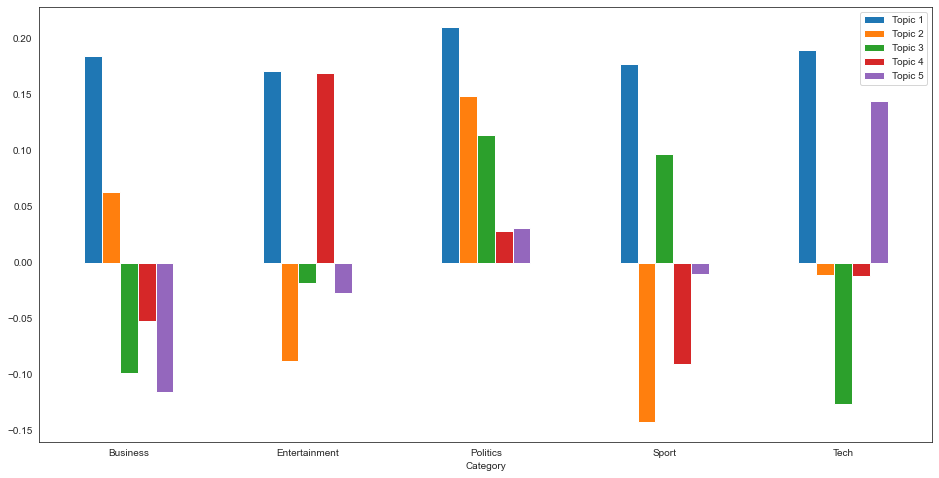

In [31]:
# Average topic weight per category
train_result = pd.DataFrame(data=train_doc_topics, columns=topic_labels, index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(16, 8), rot=0);

In [32]:
# Topics weights of most frequent words
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
film        0.096117 -0.157755 -0.037131  0.456760 -0.108419
government  0.105821  0.158542  0.050579  0.000476 -0.032035
game        0.092472 -0.165604  0.074222 -0.112915  0.056594
best        0.088036 -0.148498  0.019054  0.264735 -0.091923
uk          0.092431  0.030233 -0.055868  0.041345  0.012776
labour      0.100164  0.237937  0.227080  0.071624  0.054642
music       0.078805 -0.050253 -0.114264  0.080930  0.140046
000         0.073360  0.029985 -0.044699  0.003032 -0.013678
company     0.067638  0.024084 -0.102071 -0.028465 -0.053378
number      0.070099 -0.039725 -0.019470  0.030363  0.003596

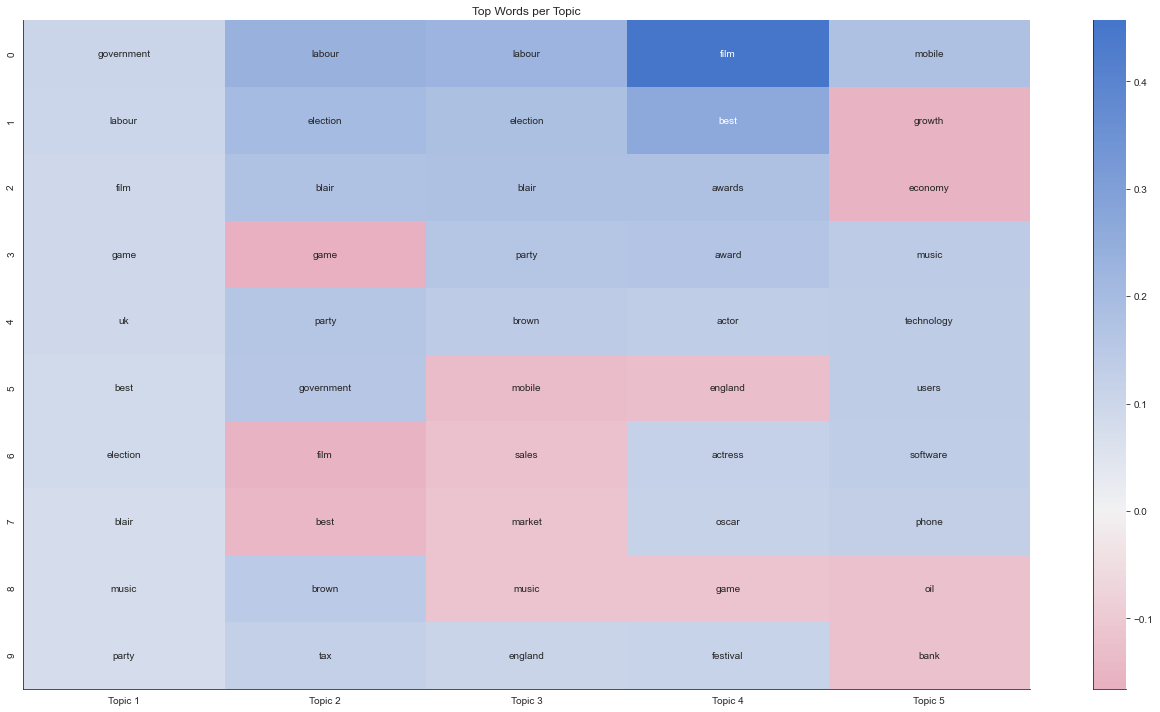

In [33]:
# Most important words by topic
fig, ax = plt.subplots(figsize=(18, 10))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), annot=top_words, fmt='', center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), ax=ax)
ax.set_title('Top Words per Topic')
sns.despine()
fig.tight_layout()

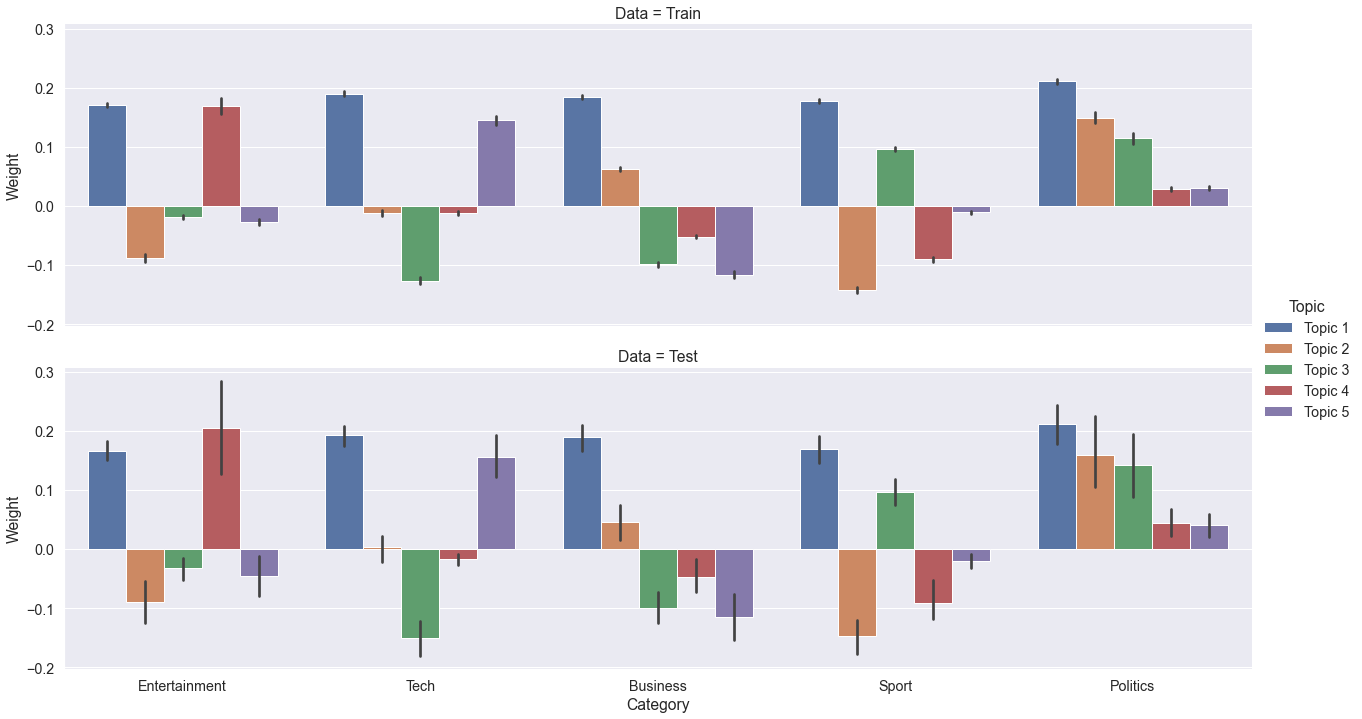

In [34]:
# Topics weights for test set
test_eval = pd.DataFrame(data=svd.transform(test_dtm), columns=topic_labels, index=test_docs.Category)
sns.set(font_scale=1.3)
result = pd.melt(train_result.assign(Data='Train').append(test_eval.assign(Data='Test')).reset_index(),
                 id_vars=['Data', 'Category'], var_name='Topic', value_name='Weight')

g = sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5);

# Topic MDLing
# Strength: noise removal, mitigation of curse of dimensionality, capturing semtnic aspects, clustering, no need the knowledge of the docus language
# Limitations: hard to interpret(included both, positive and negative), no guidance to selecting # of topics and dimensions

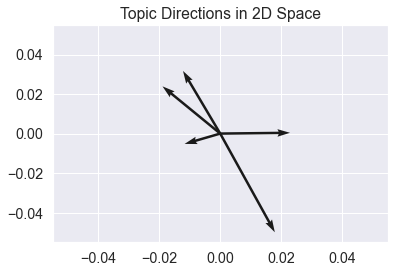

In [35]:
# Categories in 2D
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result), columns=['PC1',
                              'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()
plt.quiver(np.zeros(5), np.zeros(5), categories_2d.PC1.values, categories_2d.PC2.values, scale=.035)
plt.title('Topic Directions in 2D Space');